In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

from saving_functions import load_objects
from model_functions import nn_load
import reproducible
import no_gpu
import numpy as np
import matplotlib.pyplot as plt

In [2]:
adam_model = nn_load("../models/wine/wine_adam_E10_B32.h5")
enkf_model = nn_load("../models/wine/enkf_wine_full_E20_B200_P500_H2.h5")

In [3]:
adam_weights = adam_model.get_weights()
enkf_weights = enkf_model.get_weights()

In [4]:
layer = 0

adam_single_layer_weights = adam_weights[layer].ravel()
enkf_single_layer_weights = enkf_weights[layer].ravel()

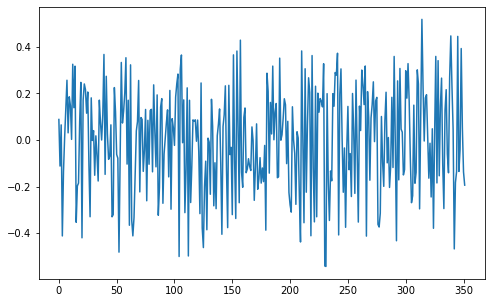

In [5]:
plt.figure(figsize = (8, 5))
plt.plot(np.arange(adam_single_layer_weights.shape[0]), adam_single_layer_weights)
plt.show()

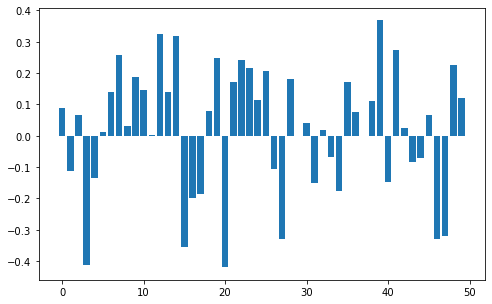

In [6]:
plt.figure(figsize = (8,5))
plt.bar(np.arange(adam_single_layer_weights.shape[0])[:50], adam_single_layer_weights[:50])
plt.show()

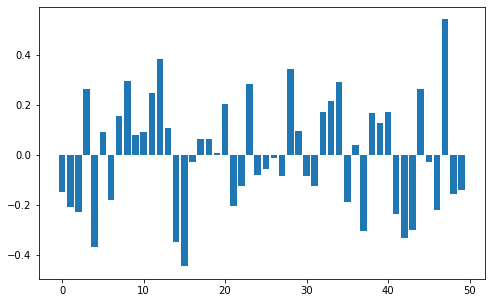

In [7]:
plt.figure(figsize = (8,5))
plt.bar(np.arange(enkf_single_layer_weights.shape[0])[:50], enkf_single_layer_weights[:50])
plt.show()

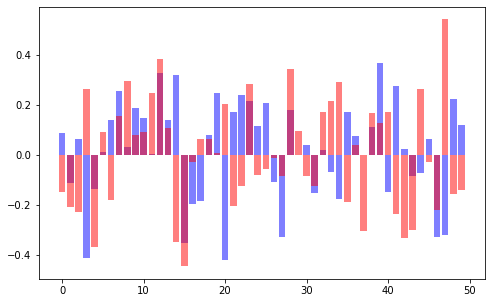

In [8]:
plt.figure(figsize = (8,5))
plt.bar(np.arange(adam_single_layer_weights.shape[0])[:50], adam_single_layer_weights[:50], alpha = 0.5, color = "b")
plt.bar(np.arange(enkf_single_layer_weights.shape[0])[:50], enkf_single_layer_weights[:50], alpha = 0.5, color = "r")
plt.show()

#### Wie man sieht, sind noch nicht einmal die Vorzeichen in den meisten Fällen gleich. Hierzu jetzt noch der genaue Prozentsatz an Vorzeichen-Übereinstimmung.

In [9]:
for i in range(len(adam_weights)):
    if i % 2 == 0:
        print("Layer {} weights with same sign: {}% out of {} weights.".format((i+1)//2+1, 
                                                                               np.round(100*np.mean(np.sign(adam_weights[i].ravel()) == np.sign(enkf_weights[i].ravel())), 2),
                                                                               adam_weights[i].ravel().shape[0]))
    else:
        print("Layer {} bias with same sign: {}% out of {} biases.".format((i+1)//2, 
                                                                            np.round(100*np.mean(np.sign(adam_weights[i].ravel()) == np.sign(enkf_weights[i].ravel())), 2),
                                                                            adam_weights[i].ravel().shape[0]))
        print("")

Layer 1 weights with same sign: 50.0% out of 352 weights.
Layer 1 bias with same sign: 46.88% out of 32 biases.

Layer 2 weights with same sign: 50.1% out of 1024 weights.
Layer 2 bias with same sign: 50.0% out of 32 biases.

Layer 3 weights with same sign: 51.56% out of 512 weights.
Layer 3 bias with same sign: 75.0% out of 16 biases.

Layer 4 weights with same sign: 43.75% out of 16 weights.
Layer 4 bias with same sign: 100.0% out of 1 biases.



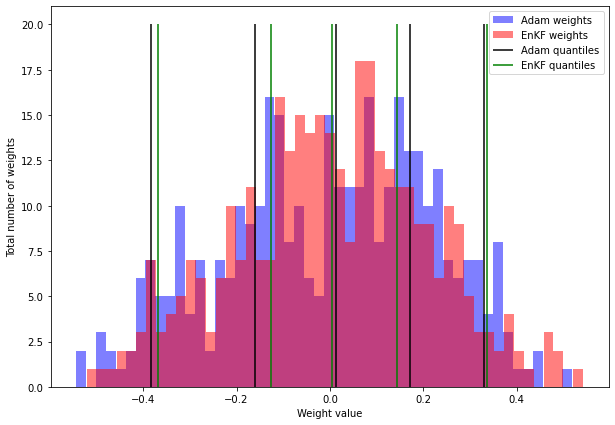

In [10]:
plt.figure(figsize = (10,7))
plt.hist(adam_single_layer_weights, alpha = 0.5, color = "b", bins = 50, label = "Adam weights")
plt.hist(enkf_single_layer_weights, alpha = 0.5, color = "r", bins = 50, label = "EnKF weights")
plt.vlines(x = np.quantile(adam_single_layer_weights, [0.05, 0.25, 0.5, 0.75, 0.95]), ymin = 0, ymax = 20, color = "k", label = "Adam quantiles")
plt.vlines(x = np.quantile(enkf_single_layer_weights, [0.05, 0.25, 0.5, 0.75, 0.95]), ymin = 0, ymax = 20, color = "g", label = "EnKF quantiles")
plt.legend(loc = "upper right")
plt.xlabel("Weight value")
plt.ylabel("Total number of weights")
plt.show()

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(adam_weights)):
    if i % 2 == 0:
        print("Cosine similarity of layer {} weights: {}".format((i+1)//2+1, 
                                                                  cosine_similarity([adam_weights[i].ravel()], [enkf_weights[i].ravel()])[0][0]))
    else:
        print("Cosine similarity of layer {} biases: {}".format((i+1)//2, 
                                                                 cosine_similarity([adam_weights[i].ravel()], [enkf_weights[i].ravel()])[0][0]))
        print("")

Cosine similarity of layer 1 weights: -0.026736613363027573
Cosine similarity of layer 1 biases: 0.10766196995973587

Cosine similarity of layer 2 weights: -0.014071912504732609
Cosine similarity of layer 2 biases: -0.23456580936908722

Cosine similarity of layer 3 weights: 0.02711397409439087
Cosine similarity of layer 3 biases: 0.27637678384780884

Cosine similarity of layer 4 weights: -0.15281423926353455
Cosine similarity of layer 4 biases: 1.0



Kosinus-Ähnlichkeit liegt zwischen -1 und 1. Ein Wert nahe Null heißt quasi keine Ähnlichkeit.

### Jetzt auch noch für die einzelnen Partikel

Kosinus-Ähnlichkeit zwischen den vollen Gewichts- und Biasvektoren der verschiedenen Partikel je Layer.

In [12]:
enkf_obs = load_objects("../objects/wine/enkf_wine_full_E20_B200_P500_H2.pckl")
weights_dict = enkf_obs["results"]["weights_dict"]

In [13]:
cosine_dict = {}
for i in range(len(weights_dict["model_1"])):
    if i % 2 == 0:
        cosine_vector = np.tril(cosine_similarity([list(weights_dict.values())[j][i].ravel() for j in range(len(weights_dict))]),k=-1).ravel()
        cosine_dict["Layer{}_weights".format((i+1)//2+1)] = np.delete(cosine_vector, np.where(cosine_vector == 0))
    else:
        cosine_vector = np.tril(cosine_similarity([list(weights_dict.values())[j][i].ravel() for j in range(len(weights_dict))]),k=-1).ravel()
        cosine_dict["Layer{}_bias".format((i+1)//2)] = np.delete(cosine_vector, np.where(cosine_vector == 0))

In [14]:
cosine_dict

{'Layer1_weights': array([0.99327485, 0.99298943, 0.99262209, ..., 0.99436495, 0.993432  ,
        0.99344686]),
 'Layer1_bias': array([0.99482873, 0.99029616, 0.99262746, ..., 0.99498758, 0.99389567,
        0.99608505]),
 'Layer2_weights': array([0.98983379, 0.98836361, 0.98841719, ..., 0.98973258, 0.98940883,
        0.98850883]),
 'Layer2_bias': array([0.99617281, 0.99350945, 0.99095869, ..., 0.99316186, 0.99223018,
        0.99113336]),
 'Layer3_weights': array([0.98951598, 0.98943433, 0.98862443, ..., 0.99123843, 0.99012339,
        0.98891932]),
 'Layer3_bias': array([0.99181291, 0.9888997 , 0.98981022, ..., 0.99254617, 0.99355449,
        0.98846079]),
 'Layer4_weights': array([0.99667029, 0.99602045, 0.99701842, ..., 0.99538261, 0.99491042,
        0.99615558]),
 'Layer4_bias': array([1., 1., 1., ..., 1., 1., 1.])}

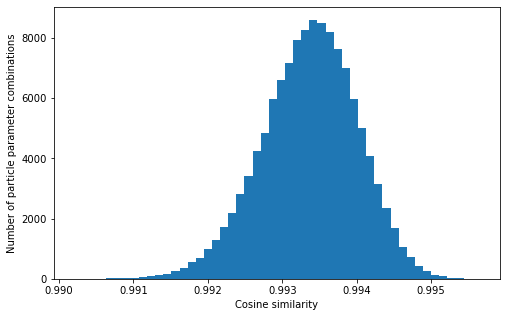

In [15]:
plt.figure(figsize = (8,5))
plt.hist(cosine_dict["Layer1_weights"], bins = 50)
plt.xlabel("Cosine similarity")
plt.ylabel("Number of particle parameter combinations")
plt.show()